In [1]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation
from keras.layers import LSTM
import pickle
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [2]:
path = 'data.txt'
text = open(path, encoding="utf8").read().lower()
print('length of the corpus is: :', len(text))

length of the corpus is: : 581888


In [3]:
# Tokenization

tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

In [9]:
# Getting unique words

unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

In [13]:
# Feature Engineering

LENGTH_WORD = 5
next_words = []
prev_words = []
for j in range(len(words) - LENGTH_WORD):
    prev_words.append(words[j:j + LENGTH_WORD])
    next_words.append(words[j + LENGTH_WORD])
print(prev_words[0])
print(next_words[0])

print(prev_words[1])
print(next_words[1])

['project', 'gutenberg', 's', 'the', 'adventures']
of
['gutenberg', 's', 'the', 'adventures', 'of']
sherlock


In [17]:
Z = np.zeros((2,2,2),  dtype=bool)

Z

array([[[False, False],
        [False, False]],

       [[False, False],
        [False, False]]])

In [18]:
# Storing Features and Labels

X = np.zeros((len(prev_words), LENGTH_WORD, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

In [19]:
# Building our model

model = Sequential()
model.add(LSTM(128, input_shape=(LENGTH_WORD, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

In [20]:
# Model Training 

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Train on 103759 samples, validate on 5462 samples
Epoch 1/20
103759/103759 [==============================] - 96s 929us/step - loss: 6.0234 - accuracy: 0.1073 - val_loss: 7.1394 - val_accuracy: 0.1007
Epoch 2/20
103759/103759 [==============================] - 97s 934us/step - loss: 5.7726 - accuracy: 0.1478 - val_loss: 7.7594 - val_accuracy: 0.1064
Epoch 3/20
103759/103759 [==============================] - 96s 922us/step - loss: 5.7474 - accuracy: 0.1764 - val_loss: 7.8174 - val_accuracy: 0.1047
Epoch 4/20
103759/103759 [==============================] - 100s 959us/step - loss: 5.4372 - accuracy: 0.2095 - val_loss: 8.3447 - val_accuracy: 0.0992
Epoch 5/20
103759/103759 [==============================] - 98s 941us/step - loss: 5.1308 - accuracy: 0.2505 - val_loss: 8.3251 - val_accuracy: 0.0881
Epoch 6/20
103759/103759 [==============================] - 96s 926us/step - loss: 4.8538 - accuracy: 0.2876 - val_loss: 8.7019 - val_accuracy: 0.0921
Epoch 7/20
103759/103759 [=================

In [21]:
# Saving Model

model.save('next_word_model_v3.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('next_word_model_v3.h5')
history = pickle.load(open("history.p", "rb"))

In [29]:
model = load_model('next_word_model_v3.h5')

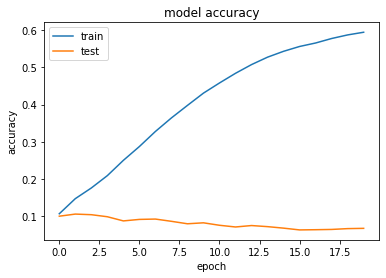

In [22]:
# Evaluating the model

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

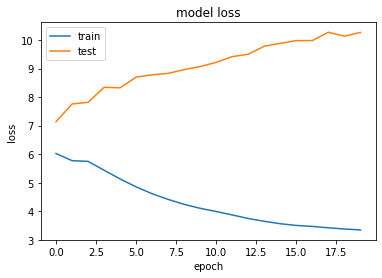

In [23]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [30]:
# Testing Next Word

def prepare_input(text):
    x = np.zeros((1, LENGTH_WORD, len(unique_words)))
    for t, word in enumerate(text.split()):
        print(word)
        try:
            x[0, t, unique_word_index[word]] = 1
        except:
            pass
    return x

In [31]:
def sample(preds, top_n):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [32]:
def predict_completions(text, n):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [unique_words[idx] for idx in next_indices]


In [38]:
quotes = [
    "had you lived a few centuries",
    "I could not help laughing at the ease with which he explained"
]

In [46]:
# Predict the next word

for q in quotes:
    seq = q[:12].lower()
    print(seq)
    print(predict_completions(seq, 10))
    print()

had you live
had
you
live
['and', 'in', 'to', 'of', 'that', 'i', 'the', 'it', 'for', 'a']

i could not 
i
could
not
['that', 'the', 'to', 'of', 'it', 'a', 'in', 'and', 'with', 'for']

